In [11]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torch.optim import Adam
from torch.autograd import Variable
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from pathlib import Path
import gdown
import time

In [2]:
%%capture
RESISC45_DIR = Path(".") / "NWPU-RESISC45"
if not RESISC45_DIR.exists():
    gdown.download(
        id="1nd0R9iljzkWd7Hhfyp2tH55KxAsKrzYj",
        output="NWPU-RESISC45.rar",
    )
    !unrar x NWPU-RESISC45.rar

In [3]:
# Find mean and standard deviation of data
def get_mean_and_std():
    transformations = transforms.Compose([transforms.ToTensor()])
    dataset = ImageFolder(root="NWPU-RESISC45", transform=transformations)
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

    mean = 0.0
    std = 0.0
    total_samples = 0

    for images, _ in loader:
        batch_size = images.size(0)
        images = images.view(batch_size, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_samples += batch_size

    mean /= total_samples
    std /= total_samples

    print(f"Mean: {mean}")
    print(f"Std: {std}")

In [4]:
# settings
mean = (0.3680, 0.3810, 0.3436)
std = (0.1454, 0.1356, 0.1320)

train_ratio = 0.8
test_ratio = 0.2

batch_size = 128
learning_rate = 0.0001

if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # to use M1 mac gpu
else:
    device = torch.device("cpu")

In [16]:
# Loading and normalizing the data.
transformations = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(mean, std)]
)

# apply normal tranformation alongside rotation of 90, 180, 270
# have to use random rotation so have lower and upper bound be the same
rotate_90 = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomRotation((90, 90)),
    ]
)

rotate_180 = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomRotation((180, 180)),
    ]
)

rotate_270 = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.RandomRotation((270, 270)),
    ]
)

# apply different transformation to same dataset
dataset = ImageFolder(root="NWPU-RESISC45", transform=transformations)
rotate_90_dataset = ImageFolder(root="NWPU-RESISC45", transform=rotate_90)
rotate_180_dataset = ImageFolder(root="NWPU-RESISC45", transform=rotate_180)
rotate_270_dataset = ImageFolder(root="NWPU-RESISC45", transform=rotate_270)

classes = dataset.class_to_idx

train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_set, test_set = random_split(dataset, [train_size, test_size])
train_set90, _ = random_split(rotate_90_dataset, [train_size, test_size])
train_set180, _ = random_split(rotate_180_dataset, [train_size, test_size])
train_set270, _ = random_split(rotate_270_dataset, [train_size, test_size])

# create loader for all the sample sets
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0)

train_90_loader = DataLoader(train_set90, batch_size=batch_size)
train_180_loader = DataLoader(train_set180, batch_size=batch_size)
train_270_loader = DataLoader(train_set270, batch_size=batch_size)

In [6]:
# Define a convolution neural network
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=20, kernel_size=3, stride=1, padding=1
        )
        self.bn1 = nn.BatchNorm2d(20)
        self.conv2 = nn.Conv2d(
            in_channels=20, out_channels=20, kernel_size=3, stride=1, padding=1
        )
        self.bn2 = nn.BatchNorm2d(20)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(
            in_channels=20, out_channels=40, kernel_size=3, stride=1, padding=1
        )
        self.bn3 = nn.BatchNorm2d(40)
        self.conv4 = nn.Conv2d(
            in_channels=40, out_channels=40, kernel_size=3, stride=1, padding=1
        )
        self.bn4 = nn.BatchNorm2d(40)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(40 * 64 * 64, 45)

    def forward(self, input):
        output = self.bn1(F.relu(self.conv1(input)))
        output = self.bn2(F.relu(self.conv2(output)))
        output = self.pool1(output)

        output = self.bn3(F.relu(self.conv3(output)))
        output = self.bn4(F.relu(self.conv4(output)))
        output = self.pool2(output)

        output = output.view(-1, 40 * 64 * 64)
        output = self.fc1(output)

        return output


# Instantiate a neural network model
model = Network()

In [7]:
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

In [33]:
# Function to save the model
def saveModel():
    path = "./augmented_base.pth"
    torch.save(model.state_dict(), path)


# Function to test the model with the test dataset and print the accuracy for the test images
def trainAccuracy():
    model.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in train_loader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = 100 * accuracy / total
    return accuracy


def testAccuracy():
    model.eval()
    accuracy = 0.0
    total = 0.0

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            # run the model on the test set to predict labels
            outputs = model(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = 100 * accuracy / total
    return accuracy


# Training function. We simply have to loop over our data iterator and feed the inputs to the network and optimize.
def train(num_epochs):
    train_acc_list = []
    test_acc_list = []
    loss_list = []
    best_accuracy = 0.0

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        model.train()

        epoch_loss = []
        running_loss = 0.0
        running_acc = 0.0
        for folder in [
            train_loader,
            train_90_loader,
            train_180_loader,
            train_270_loader,
        ]:
            for i, (images, labels) in enumerate(folder, 0):
                # get the inputs
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))

                # zero the parameter gradients
                optimizer.zero_grad()
                # predict classes using images from the training set
                outputs = model(images)
                # compute the loss based on model output and real labels
                loss = loss_fn(outputs, labels)
                # backpropagate the loss
                loss.backward()
                # adjust parameters based on the calculated gradients
                optimizer.step()

                # add loss to epoch
                epoch_loss.append(loss.detach().item())

                # Let's print statistics for every 100 images
                running_loss += loss.item()  # extract the loss value
                if i % 100 == 99:
                    # print every 100 images
                    print(
                        f"[Epoch {epoch + 1:2d}]: "
                        f"Average loss at {i + 1:3d} iterations: {running_loss / (i + 1):.3f}"
                    )

        # average the loss in the previous epoch
        loss_list.append(np.mean(epoch_loss))
        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        train_accuracy = trainAccuracy()
        train_acc_list.append(train_accuracy)
        print(
            "For epoch",
            epoch + 1,
            "the train accuracy over the whole test set is %d %%" % (train_accuracy),
        )
        test_accuracy = testAccuracy()
        test_acc_list.append(test_accuracy)
        print(
            "For epoch",
            epoch + 1,
            "the test accuracy over the whole test set is %d %%" % (test_accuracy),
        )

        print(f"Loss list:  {loss_list}")
        print(f"Train Accuracy list:  {train_acc_list}")
        print(f"Test Accuracy list:  {test_acc_list}")

        # we want to save the model if the accuracy is the best
        if test_accuracy > best_accuracy:
            saveModel()
            best_accuracy = test_accuracy
    return train_acc_list, test_acc_list, loss_list

In [27]:
import matplotlib.pyplot as plt
import numpy as np


# Function to show the images
def show_image(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Function to test the model with a batch of images and show the labels predictions
def testBatch():
    class_list = list(classes.keys())

    # get batch of images from the test DataLoader
    images, labels = next(iter(test_loader))

    # show all images as one image grid
    show_image(torchvision.utils.make_grid(images))

    # Get a tuple of real labels
    real_labels = (class_list[labels[j]] for j in range(batch_size))

    # Let's see what if the model identifiers the  labels of those example
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)

    # We got the probability for every 10 labels. The highest (max) probability should be correct label
    _, predicted = torch.max(outputs, 1)

    # Let's show the predicted labels on the screen to compare with the real ones
    predicted_labels = (class_list[predicted[j]] for j in range(batch_size))

    print(f"{'Real':25s}| {'Predicted':25s}| Match")
    print("-" * 25 + "+" + "-" * 27 + "+" + "-" * 6)

    for real, pred in zip(real_labels, predicted_labels, strict=True):
        match_char = "✅" if real == pred else "❌"
        print(f"{real:25s}|  {pred:25s}| {match_char}")

In [19]:
start_time = time.time()
# Let's build our model
train_acc, test_acc, loss_list = train(10)
print("Finished Training")
print(f"Time Taken to train: {(time.time() - start_time)/60} minutes")

# unaugmented had baseline of 43%
# Test which classes performed well
testAccuracy()

# Let's load the model we just created and test the accuracy per label
model = Network()
path = "augmented_base.pth"
model.load_state_dict(torch.load(path))

The model will be running on cuda:0 device
[Epoch  1]: Average loss at 100 iterations: 0.038
[Epoch  1]: Average loss at 100 iterations: 6.151
[Epoch  1]: Average loss at 100 iterations: 15.205
[Epoch  1]: Average loss at 100 iterations: 22.816
For epoch 1 the train accuracy over the whole test set is 68 %
For epoch 1 the test accuracy over the whole test set is 66 %
Loss list:  [3.330933398417041]
Train Accuracy list:  [68.07539682539682]
Test Accuracy list:  [66.41269841269842]
[Epoch  2]: Average loss at 100 iterations: 1.481
[Epoch  2]: Average loss at 100 iterations: 3.287
[Epoch  2]: Average loss at 100 iterations: 5.172
[Epoch  2]: Average loss at 100 iterations: 7.149
For epoch 2 the train accuracy over the whole test set is 88 %
For epoch 2 the test accuracy over the whole test set is 71 %
Loss list:  [3.330933398417041, 1.039264408786436]
Train Accuracy list:  [68.07539682539682, 88.7420634920635]
Test Accuracy list:  [66.41269841269842, 71.23809523809524]
[Epoch  3]: Average

<All keys matched successfully>

In [25]:
model = Network()
path = "augmented_base.pth"
model.load_state_dict(torch.load(path))
# pass model to gpu because it will reside on cpu when loaded if needed
if torch.cuda.is_available():
    model.cuda()

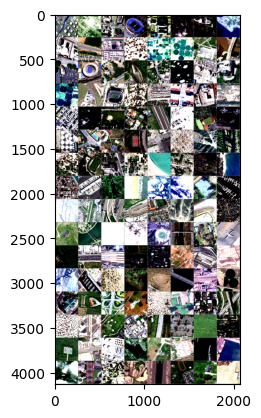

Real                     | Predicted                | Match
-------------------------+---------------------------+------
storage_tank             |  thermal_power_station    | ❌
airport                  |  airport                  | ✅
intersection             |  intersection             | ✅
stadium                  |  lake                     | ❌
palace                   |  lake                     | ❌
thermal_power_station    |  thermal_power_station    | ✅
sparse_residential       |  golf_course              | ❌
beach                    |  island                   | ❌
storage_tank             |  storage_tank             | ✅
freeway                  |  mountain                 | ❌
storage_tank             |  stadium                  | ❌
chaparral                |  chaparral                | ✅
circular_farmland        |  circular_farmland        | ✅
circular_farmland        |  lake                     | ❌
airport                  |  airport                  | ✅
bridge                  

In [28]:
testBatch()

In [47]:
# function originall did not return list so manual input
# above code should be able to store the list
train_acc = [
    68.07539682539682,
    88.7420634920635,
    92.38888888888889,
    94.17857142857143,
    93.88492063492063,
    92.85714285714286,
    95.18253968253968,
    96.60714285714286,
    96.82936507936508,
    97.7063492063492,
]
test_acc = [
    66.41269841269842,
    71.23809523809524,
    70.23809523809524,
    68.85714285714286,
    67.23809523809524,
    64.98412698412699,
    65.71428571428571,
    66.34920634920636,
    65.73015873015873,
    65.84126984126983,
]
loss_list = [
    3.330933398417041,
    1.039264408786436,
    0.3363465136673472,
    0.1875084757043739,
    0.15989651581979247,
    0.14505774801984656,
    0.1461693575507654,
    0.12166964845746037,
    0.10094155979858059,
    0.09371168039967236,
]

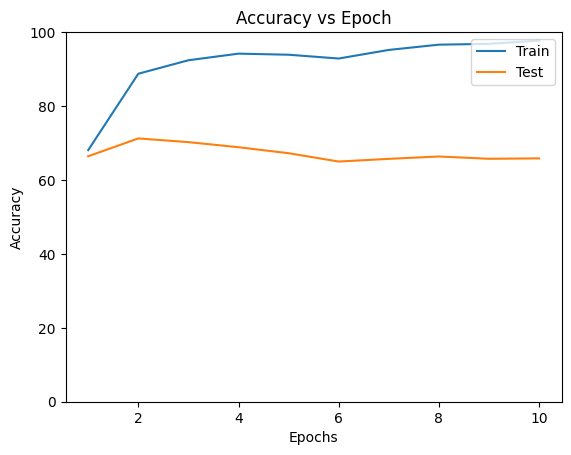

In [52]:
plt.plot(range(1, 11), train_acc, label="Train")
plt.plot(range(1, 11), test_acc, label="Test")
plt.legend(loc="upper right")
plt.ylim(0, 100)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.show()

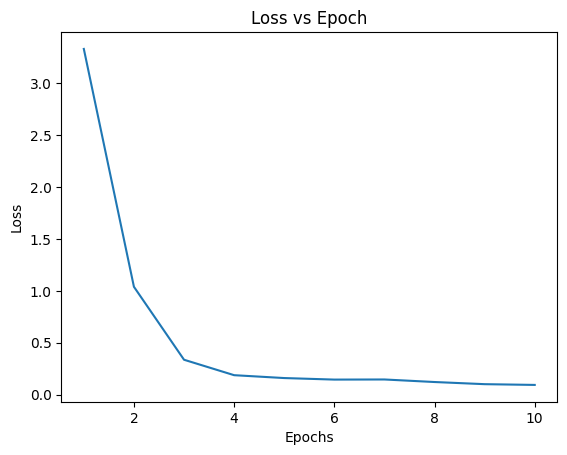

In [39]:
plt.plot(range(1, 11), loss_list)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()